In [49]:
import numpy as np
# import xarray as xr
import matplotlib.pyplot as plt
# from matplotlib.patches import Rectangle
# from mpl_toolkits.basemap import Basemap
# from scipy.io import loadmat
from cmocean import cm
import pandas as pd
import warnings
import pickle
import arrow
#from cartopy import crs, feature
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from salishsea_tools import viz_tools
import netCDF4 as nc
import glob

#import LambertConformalTicks as lct

%matplotlib inline
plt.rcParams['font.size'] = 11
warnings.simplefilter('ignore')


In [50]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

### Part 2: What sort of metrics are coming out, do they make sense, do I understand the units, and what does the budget look like?

Governing equations of the system (as written in MM16):

$\frac{\partial DIC}{\partial t } = - (U_{N} + U_{PC} - Rm_{N}) * R_{C:N} + {physical transport} + {airsea flux} $ 

$\frac{\partial TA}{\partial t } = U_{NO3-} - 2Rm_{NO3-} - U_{NH4+} + Rm_{NH4+} + (U_{PO4} + Rm_{PO4})* R_{N:P} + {physical transport}$ 


The model code:

DIC:

                zz_loc_remin_NH4 = (zz_remin_D_DON*trn(ji,jj,jk,jpdon) + zz_remin_D_PON*trn(ji,jj,jk,jppon)) *tgfunc(ji,jj,jk)

               tra(ji,jj,jk,jpdic) = tra(ji,jj,jk,jpdic) + ( zz_loc_remin_NH4 - &
               (zz_uptake_NO_diat(ji,jj,jk)+zz_uptake_NH_diat(ji,jj,jk)+zz_uptake_PC_diat(ji,jj,jk) + &
               zz_uptake_NO_nano(ji,jj,jk)+zz_uptake_NH_nano(ji,jj,jk)+zz_uptake_PC_nano(ji,jj,jk) + &
               zz_uptake_NO_myri(ji,jj,jk)+zz_uptake_NH_myri(ji,jj,jk)+zz_uptake_PC_myri(ji,jj,jk)) &
                ) * zz_redfield_c_n

TA:

                 zz_loc_remin_NH4 = (zz_remin_D_DON*trn(ji,jj,jk,jpdon) + zz_remin_D_PON*trn(ji,jj,jk,jppon)) *tgfunc(ji,jj,jk)
                 zz_loc_oxy_NH4 = zz_remin_NH * trn(ji,jj,jk,jpnh4) ** 2 * tgfunc(ji,jj,jk)

                tra(ji,jj,jk,jpta) =tra(ji,jj,jk,jpta)+ ((zz_redfield_p_n + 1.0) * &
                (zz_uptake_NO_diat(ji,jj,jk)+ &
                zz_uptake_NO_myri(ji,jj,jk)+&
                zz_uptake_NO_nano(ji,jj,jk))+ &
                (zz_redfield_p_n - 1.0) * &
                (zz_uptake_NH_diat(ji,jj,jk)+ &
                 zz_uptake_NH_myri(ji,jj,jk)+&
                 zz_uptake_NH_nano(ji,jj,jk) &
                 - zz_loc_remin_NH4)  - 2 * zz_loc_oxy_NH4)
                 
                 
Notes: 

- PRD_DIC gives us the change in DIC from the p4zcar.f90 module + the air-sea flux (p4zflx.f90), both of which are called in p4zprod.f90. Because the p4zrem.f90 module doesn't act on DIC in any way, REM_DIC is 0.

- So PRD_DIC gives us the total non-physical-transport change in DIC in a given timeperiod, in mmol DIC/s

- we can rewrite PRD_DIC (which we can think of as $\Delta$DIC without physical transport) into its component parts and get it out as follows:



- PRD_DIC = ( [remineralization (nitrogen-based)] - [uptake (nitrogen-based)] - [uptake (uncoupled carbon]) * REDFIELDRAT + air-sea flux


- We then have to account for 4 things:


- remineralization = (REM_DON + REM_PON) > we explicitly have these, they should be negative (decrease in organics) values that we flip the sign for

- nitrogen-tied uptake = (PRD_NO3 + PRD_NH4) > we also explicitly have these.  they should be negative (decrease in nitrate and ammonium due to biological uptake). 

- uptake of uncoupled carbon > we do not have this, we shall have to treat it as the remainder of the other 3 things. 

- air-sea flux > we do not explicitly have this. we have co2flux in mmol/m2/s, but we then have to multiply by the amount of meters2 in a given grid cell to square with what's being output by PRD_DIC. It is only relevant in the top grid cell.


## check PRD_DIC > PRD_DIC should be close to (PRD_NIT +PRD_NH4) x 106/16

In [51]:
q = '/data/tjarniko/results/FUTURE_runs/01jan17_PROD3/'

#this is in mmol N /s

prdrem_02jan = nc.Dataset(f'{q}SalishSeaCast_1d_20170101_20170102_PRDREM_T_20170102-20170102.nc')
print(prdrem_02jan)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    name: SalishSeaCast_1d_20170101_20170102_PRDREM_T
    description: production remineralization
    title: production remineralization
    Conventions: CF-1.6
    timeStamp: 2021-Jul-12 18:51:55 GMT
    uuid: d1ddff66-bd14-4a35-b440-9d49bf97c0d5
    dimensions(sizes): axis_nbounds(2), x(398), y(898), nvertex(4), deptht(40), time_counter(1)
    variables(dimensions): float32 nav_lat(y,x), float32 nav_lon(y,x), float32 bounds_nav_lon(y,x,nvertex), float32 bounds_nav_lat(y,x,nvertex), float32 area(y,x), float32 deptht(deptht), float32 deptht_bounds(deptht,axis_nbounds), float64 time_centered(time_counter), float64 time_centered_bounds(time_counter,axis_nbounds), float64 time_counter(time_counter), float64 time_counter_bounds(time_counter,axis_nbounds), float32 PRD nitrate(time_counter,deptht,y,x), float32 PRD ammonium(time_counter,deptht,y,x), float32 PRD particulate_organic_nitrogen(time_counter,dept

In [52]:
REDRAT = 106/16

DEL_DIC = prdrem_02jan['PRD DIC'][:]
#remineralization metrics
REM_PON = prdrem_02jan['REM particulate_organic_nitrogen'][:]
REM_DON = prdrem_02jan['REM dissolved_organic_nitrogen'][:]

REM_DIC = -1 * (REM_PON+ REM_DON)*REDRAT

PRD_NIT = prdrem_02jan['PRD nitrate'][:]
PRD_NH = prdrem_02jan['PRD ammonium'][:]

#uptake DIC so that it's not confusing
UPT_DIC = (PRD_NIT+PRD_NH)*REDRAT

print('at x=250, y = 250, calculated. remineralization of DIC, mmol/S')
print(REM_DIC[0,:,250,250])

print('at x=250, y = 250, calc. uptake of DIC, mmol/S')
print(UPT_DIC[0,:,250,250])

print('at x=250, y = 250, sum of calcul-remin and calcul-uptake \n doesnt include uncoupled C uptake')
print(REM_DIC[0,:,250,250]+UPT_DIC[0,:,250,250])

print('at x=250, y = 250, output of PRD DIC (aka DEL DIC, should be the sameish)')
print(DEL_DIC[0,:,250,250])

# rem_nit = prdrem_02jan['REM nitrate'][:]
# prd_nit = prdrem_02jan['PRD nitrate'][:]
# prd_nh4 = prdrem_02jan['PRD ammonium'][:]

# prd_DIC = prdrem_02jan['PRD DIC'][:]
# rem_DIC = prdrem_02jan['REM DIC'][:]
# #REM ammonium
# sum_nit = prd_nit[0,:,250,250] + prd_nh4[0,:,250,250]
# # print(prd_nit[0,:,250,250])
# # print(prd_nh4[0,:,250,250])
# print('sum nitrogen uptake (at one point, x = 250, y = 250, depth profile)')
# print(sum_nit)
# print('nitrogen uptake x redfield ratio')
# print(sum_nit * 106/16)
# print()
# print('DIC uptake (PRD_DIC)')
# print(prd_DIC[0,:,250,250])""
# print('DIC remineralization (REM_DIC)')
# print(rem_DIC[0,:,250,250])

print()

at x=250, y = 250, calculated. remineralization of DIC, mmol/S
[0.12011880427598953 0.12021129578351974 0.12029534578323364
 0.12037376314401627 0.12045584619045258 0.12057393044233322
 0.1207052543759346 0.12079839408397675 0.12090425938367844
 0.12104625999927521 0.12127604335546494 0.1216835081577301
 0.12243617326021194 0.12386614829301834 0.12661242485046387
 0.13191603124141693 0.14216001331806183 0.16189658641815186
 0.19961674511432648 0.2705329358577728 0.3996366262435913
 0.6220316886901855 0.9650702476501465 1.3851141929626465
 1.7580013275146484 1.9161772727966309 1.9729561805725098
 1.2278200387954712 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
at x=250, y = 250, calc. uptake of DIC, mmol/S
[-1.0835931301116943 -1.0771489143371582 -1.0569393634796143
 -1.0297338962554932 -0.9960201382637024 -0.9593551158905029
 -0.9221716523170471 -0.8876991868019104 -0.8546157479286194
 -0.822629451751709 -0.7913112044334412 -0.7604485750198364
 -0.7296214699745178 -0.699452221393585

-- why does PRD_DIC change sign? SOLVED
-- why is it -184 in the surface cell? (likely air-sea flux --- if it's mmol/s) SOLVED
-- REM_DIC is not being printed out appropriately SOLVED
-- this looks like PRD_DIC simply gives you the change in DIC and you can try to account for bits of it by separating it up into component parts as per the equations? check with elise YEP THAT'S THE ONE


In [53]:
DEL_DIC = prdrem_02jan['PRD DIC'][:]
#remineralization metrics
REM_PON = prdrem_02jan['REM particulate_organic_nitrogen'][:]
REM_DON = prdrem_02jan['REM dissolved_organic_nitrogen'][:]

REM_DIC = -1 * (REM_PON+ REM_DON)*REDRAT

PRD_NIT = prdrem_02jan['PRD nitrate'][:]
PRD_NH = prdrem_02jan['PRD ammonium'][:]

#uptake DIC so that it's not confusing
UPT_DIC = (PRD_NIT+PRD_NH)*REDRAT

DEL_DIC[:,0,:,:] = np.nan
UPT_DIC[:,0,:,:] = np.nan
REM_DIC[:,0,:,:] = np.nan

## don't worry about surface - copy relevant and set to nan at surface for now. 

## calculate A NUMBER for UPT, REM, UPT+REM, DEL, 
sum_UPT_DIC = np.nansum(UPT_DIC)
sum_REM_DIC = np.nansum(REM_DIC)
sum_U_R_DIC = sum_UPT_DIC + sum_REM_DIC
sum_DEL_DIC = np.nansum(DEL_DIC)

print('for one day (jan 2):')
print('sum of calculated-from-N-uptake')
print(sum_UPT_DIC)
print('sum of calculated-from-N-remin')
print(sum_REM_DIC)
print('sum of above 2 terms')
print(sum_U_R_DIC)
print('sum of output PRD DIC (aka DEL DIC)')
print(sum_DEL_DIC)
## put in a loop to do for everything you've got. 


for one day (jan 2):
sum of calculated-from-N-uptake
-1467960.1
sum of calculated-from-N-remin
786269.56
sum of above 2 terms
-681690.56
sum of output PRD DIC (aka DEL DIC)
-682825.9


Notes: these should be similar:

    sum of above 2 terms
    -681690.56
    sum of output PRD DIC (aka DEL DIC)
    -682825.9
    
AND THEY ARE!

- Note, this doesn't include uncoupled C uptake (shouldn't really be a big term)
- it also doesn't deal with the surface cell (set to nan for all terms in this calculation - we need to deal with surface air-sea flux which is the dominant term there and may introduce rounding errors)


In [54]:
# ## extract data

# start ='2017-01-01'
# end ='2017-03-01'

# start_run = arrow.get(start)
# end_run = arrow.get(end)

# arrow_array = []

# for r in arrow.Arrow.span_range('day', start_run, end_run):
#     arrow_array.append(r)

# dayslen = len(arrow_array)

# # BUDGET_DIC = np.zeros([dayslen,40,898,398])
# # BUDGET_CO2 = np.zeros([dayslen,898,398])

# # BUDGET_NIT = np.zeros([dayslen,40,898,398])
# # BUDGET_DIAT = np.zeros([dayslen,40,898,398])

# # BUDGET_TEMP = np.zeros([dayslen,40,898,398])
# # BUDGET_SAL = np.zeros([dayslen,40,898,398])

# sum_UPT_DIC_ar = np.zeros(dayslen)
# sum_REM_DIC_ar = np.zeros(dayslen)
# sum_U_R_DIC_ar = np.zeros(dayslen)
# sum_DEL_DIC_ar = np.zeros(dayslen)

# #print(sum_UPT_DIC_ar)

# for i in range(0,dayslen):

#     tdate = arrow_array[i][0]
#     ymd = tdate.format('YYYYMMDD')

#     #if i%10 == 0:
#     print(ymd)
    
#     findfil_carp = f'/data/tjarniko/results/FUTURE_runs/BUDGET/*/SalishSeaCast_1d_*PRDREM*{ymd}.nc'
#     foundfil_carp = glob.glob(findfil_carp)
#     prdrem = nc.Dataset(foundfil_carp[0])
    
#     DEL_DIC = prdrem['PRD DIC'][:]
#     #remineralization metrics
#     REM_PON = prdrem['REM particulate_organic_nitrogen'][:]
#     REM_DON = prdrem['REM dissolved_organic_nitrogen'][:]

#     REM_DIC = -1 * (REM_PON+ REM_DON)*REDRAT

#     PRD_NIT = prdrem['PRD nitrate'][:]
#     PRD_NH = prdrem['PRD ammonium'][:]

#     #uptake DIC so that it's not confusing
#     UPT_DIC = (PRD_NIT+PRD_NH)*REDRAT

#     DEL_DIC[:,0,:,:] = np.nan
#     UPT_DIC[:,0,:,:] = np.nan
#     REM_DIC[:,0,:,:] = np.nan

#     ## don't worry about surface - copy relevant and set to nan at surface for now. 

#     ## calculate A NUMBER for UPT, REM, UPT+REM, DEL, 
#     sum_UPT_DIC = np.nansum(UPT_DIC)
#     sum_REM_DIC = np.nansum(REM_DIC)
#     sum_U_R_DIC = sum_UPT_DIC + sum_REM_DIC
#     sum_DEL_DIC = np.nansum(DEL_DIC)
    
#     sum_UPT_DIC_ar[i] = sum_UPT_DIC
#     sum_REM_DIC_ar[i] = sum_REM_DIC
#     sum_U_R_DIC_ar[i] = sum_U_R_DIC
#     sum_DEL_DIC_ar[i] = sum_DEL_DIC
    
# pickle.dump(sum_UPT_DIC_ar, open("./pkls/sum_UPT_DIC_ar.pkl", 'wb'))
# pickle.dump(sum_REM_DIC_ar, open("./pkls/sum_REM_DIC_ar.pkl", 'wb'))
# pickle.dump(sum_U_R_DIC_ar, open("./pkls/sum_U_R_DIC_ar.pkl", 'wb'))
# pickle.dump(sum_DEL_DIC_ar, open("./pkls/sum_DEL_DIC_ar.pkl", 'wb'))

# # pickle.dump(BUDGET_DIC, open("./pkls/BUDGET_DIC.pkl", 'wb'))
# # pickle.dump(BUDGET_CO2, open("./pkls/BUDGET_CO2.pkl", 'wb'))


In [55]:
# pickle.dump(sum_UPT_DIC_ar, open("./pkls/sum_UPT_DIC_ar.pkl", 'wb'))
# pickle.dump(sum_REM_DIC_ar, open("./pkls/sum_REM_DIC_ar.pkl", 'wb'))
# pickle.dump(sum_U_R_DIC_ar, open("./pkls/sum_U_R_DIC_ar.pkl", 'wb'))
# pickle.dump(sum_DEL_DIC_ar, open("./pkls/sum_DEL_DIC_ar.pkl", 'wb'))

sum_UPT_DIC_ar = pickle.load(open('./pkls/sum_UPT_DIC_ar.pkl', 'rb'))
sum_REM_DIC_ar = pickle.load(open('./pkls/sum_REM_DIC_ar.pkl', 'rb'))
sum_U_R_DIC_ar = pickle.load(open('./pkls/sum_U_R_DIC_ar.pkl', 'rb'))
sum_DEL_DIC_ar = pickle.load(open('./pkls/sum_DEL_DIC_ar.pkl', 'rb'))


Text(0.5, 0.98, 'preliminary budget - domain-wide sums, DIC uptake and remineralization balance. \n  top cell ignored for now \n PRD_DIC squares nicely with backcalculated nitrogen terms, which is a GOOD THING. \n why remin monotonic? talk to elise')

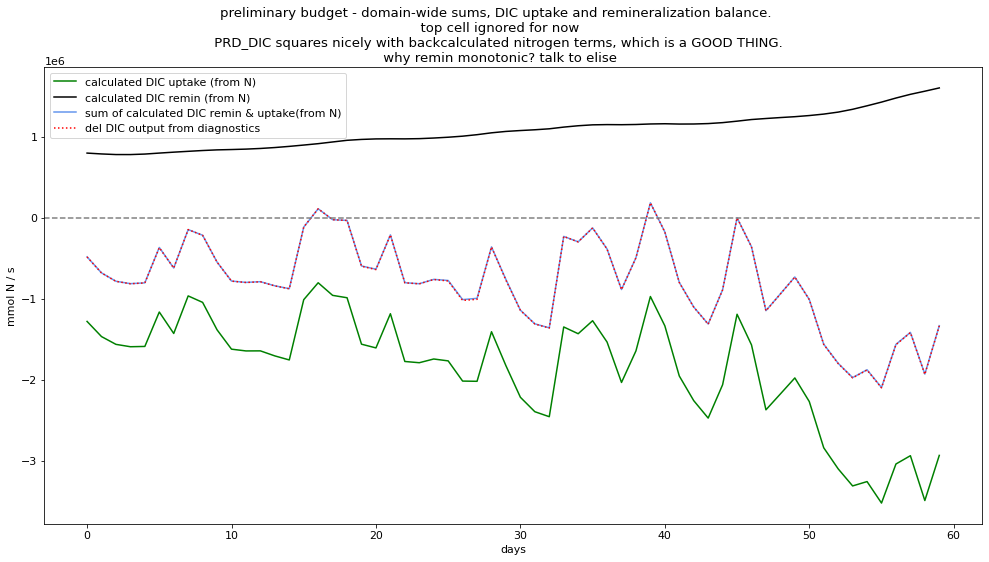

In [58]:
## plotting
fact = 0.5
daze = np.arange(0,dayslen,1)

w = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
td = (w['gdept_1d'][0,:])
fact = 0.6

fig, axs = plt.subplots(1,1, figsize=(28*fact, 14*fact), facecolor='w', edgecolor='k')
#axs = axs.ravel()

axs.plot(daze,sum_UPT_DIC_ar, color = 'g',linestyle = '-', label = 'calculated DIC uptake (from N)')
axs.plot(daze,sum_REM_DIC_ar, color = 'k',linestyle = '-', label = 'calculated DIC remin (from N)')
axs.plot(daze,sum_U_R_DIC_ar, color = 'cornflowerblue',\
         linestyle = '-', label = 'sum of calculated DIC remin & uptake(from N)')
axs.plot(daze,sum_DEL_DIC_ar, color = 'r',\
         linestyle = ':', label = 'del DIC output from diagnostics')
axs.axhline(y= 0, linestyle = '--', color = 'grey')
axs.legend(loc = 'best')
axs.set_xlabel('days'); axs.set_ylabel('mmol N / s')
plt.suptitle('preliminary budget - domain-wide sums, DIC uptake and remineralization balance. \n  top cell ignored for now \n PRD_DIC squares nicely with backcalculated nitrogen terms, which is a GOOD THING. \n why remin monotonic? talk to elise')